## Overview

* The ContractNLI dataset is a collection of natural language inference (NLI) examples on contracts. It contains 14,034 examples for training, 3,000 for validation, and 3,000 for testing.
* NLI is indeed a popular NLP task that has been studied extensively in recent years, and has important applications in areas such as information retrieval, question answering, and dialogue systems.
* I downloaded the ContractNLI dataset from https://stanfordnlp.github.io/contract-nli/.

In [1]:
! pip install transformers

## Import some modules

In [2]:
# Import Necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import csv
import json

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader


from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import random
import spacy

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Convert the data to CSV

I converted json files to CSV files to make it easier to deal with:
1. I loaded the json files for the train sets using the Json.load() and assigned the resulting dictionary to the variable data.
2. I extracted the documents and labels lists from the data dictionary using the corresponding keys.
3. I used a for loop to iterate over each document in the documents list and extracted the relevant information for each hypothesis, including the document ID, text, hypothesis, label, and evidence spans.
4. For each hypothesis, I appended a new row to a list called rows that contained the extracted information.
5. After iterating over all documents and hypotheses, I constructed a pandas DataFrame from the rows list and assigned it to the variable df.
6. The datasets should contain 4 features:
    * "text": the text of the contract
    * "hypothesis": the hypothesis text
    * "label": the label (one of "entailment", "contradiction", or "neutral")
    * "evidence_spans": a list of evidence spans (if any) associated with the hypothesis, where each span is represented as a pair of start and end character indices
7.  I wrote the DataFrame to a CSV file using the to_csv() method.

In [3]:
with open('/kaggle/input/nplcontractnli/train.json') as f:
    data = json.load(f)
    
documents = data['documents']
labels = data['labels']

rows = []
for doc in documents:
    doc_id = doc['id'] 
    text = doc['text']  
    for annotation_key in doc['annotation_sets'][0]['annotations']:  
        hyp_key = annotation_key    
        label = doc['annotation_sets'][0]['annotations'][hyp_key]['choice']   
        spans = doc['annotation_sets'][0]['annotations'][hyp_key]['spans'] 
        hyp = labels[hyp_key]['hypothesis']
        rows.append([doc_id, text, hyp, label, spans])
        
# Write to CSV        
df = pd.DataFrame(rows, columns=['doc_id', 'text', 'hypothesis', 'label', 'spans'])  
df.to_csv('train.csv', index=False)

In [4]:
# Load the train.csv file 
train = pd.read_csv('train.csv')

# Display the first few rows of the DataFrame
train.head()

,doc_id,text,hypothesis,label,spans
0,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment,"[39, 40]"
2,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment,[38]
3,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment,[51]
4,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned,[]


In [5]:
with open('/kaggle/input/nplcontractnli/dev.json') as f:
    data = json.load(f)
    
documents = data['documents']
labels = data['labels']

rows = []
for doc in documents:
    doc_id = doc['id'] 
    text = doc['text']  
    for annotation_key in doc['annotation_sets'][0]['annotations']:  
        hyp_key = annotation_key    
        label = doc['annotation_sets'][0]['annotations'][hyp_key]['choice']   
        spans = doc['annotation_sets'][0]['annotations'][hyp_key]['spans'] 
        hyp = labels[hyp_key]['hypothesis']
        rows.append([doc_id, text, hyp, label, spans])
        
# Write to CSV        
df = pd.DataFrame(rows, columns=['doc_id', 'text', 'hypothesis', 'label', 'spans'])  
df.to_csv('val.csv', index=False)

In [6]:
# Load the val.csv file 
val = pd.read_csv('val.csv')
# Display the first few rows of the DataFrame
val.head()

,doc_id,text,hypothesis,label,spans
0,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,"[33, 39]"
1,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,[47]
2,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment,[51]
3,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment,"[89, 90]"
4,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction,[17]


In [7]:
with open('/kaggle/input/nplcontractnli/test.json') as f:
    data = json.load(f)
    
documents = data['documents']
labels = data['labels']

rows = []
for doc in documents:
    doc_id = doc['id'] 
    text = doc['text']  
    for annotation_key in doc['annotation_sets'][0]['annotations']:  
        hyp_key = annotation_key    
        label = doc['annotation_sets'][0]['annotations'][hyp_key]['choice']   
        spans = doc['annotation_sets'][0]['annotations'][hyp_key]['spans'] 
        hyp = labels[hyp_key]['hypothesis']
        rows.append([doc_id, text, hyp, label, spans])
        
# Write to CSV        
df = pd.DataFrame(rows, columns=['doc_id', 'text', 'hypothesis', 'label', 'spans'])  
df.to_csv('test.csv', index=False)

In [8]:
# Load the test.csv file into a pandas DataFrame
test = pd.read_csv('test.csv')

# Display the first few rows of the DataFrame
test.head()

,doc_id,text,hypothesis,label,spans
0,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,"[84, 85, 86]"
2,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,[45]
3,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,[]
4,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,"[25, 32]"


In [9]:
# Convert the "text" column to a list
test_texts = test["text"].tolist()
# Convert the "hypothesis" column  to a list
test_hypotheses = test["hypothesis"].tolist()

In [10]:
# Calculate the number of documents in each set
num_train_docs = len(train['doc_id'].unique())
num_val_docs = len(val['text'].unique())
num_test_docs = len(test['doc_id'].unique())

print(f"Number of documents in train set: {num_train_docs}")
print(f"Number of documents in validation set: {num_val_docs}")
print(f"Number of documents in test set: {num_test_docs}")

Number of documents in train set: 423
Number of documents in validation set: 61
Number of documents in test set: 123


In [11]:
# Calculate the length of each document
train_doc_lengths = train.groupby('doc_id')['text'].apply(lambda x: len(x.iloc[0])).values
val_doc_lengths = val.groupby('text')['text'].apply(lambda x: len(x.iloc[0])).values
test_doc_lengths = test.groupby('doc_id')['text'].apply(lambda x: len(x.iloc[0])).values

print("Train document lengths:", train_doc_lengths)
print("Validation document lengths:", val_doc_lengths)
print("Test document lengths:", test_doc_lengths)

Train document lengths: [ 8585 14944 14967  7503 23380 14234 10209  3519  6384 19009  8179 10259
  6476 11233  7850  3574  3713 10715 10763  5217 12079  2675  5076  2907
 10439 15990 13860  5254 10967  5289  4062  6110  3584  1858  4916  9781
 19717 17105  8285 13539  5205 17266 10704  5061 19025  4850  4895  3590
 12222  6122 10152 10577  4612 13012  7227  8937 24294 12540  8804  8273
  7169 10449 11231 10645 12037 14082 40673 11356 13724 12635  4804  5166
 16694 13445  6373 11268  7483  9263  3564  6981  4398  8705  4344 10464
  9394  6444  7571  6691  6567 10828  8256 12576 10380 11532  5953 11806
 15646  7291 10545  6981  8366 11721 20129  6366  9361  6006  4810 11180
 10933  7929  3822  5221  9254  4560  6148 12802 10750 12472 10280 11883
  4520  3908  9552  9707  9768  6217  3616  4051 11481 10462  7601  2041
  2712  4558  8548 14078  7380 14938  3676 14958  7261 33405 19254  6302
  3127  6654  6622 11831  8741  9071 21912  2697  6009 11921  3532  9251
  5084  6876  9241  9906  6

In [12]:
# Calculate the length of each hypothesis
train_hyp_lengths = train['hypothesis'].apply(len).values
val_hyp_lengths = val['hypothesis'].apply(len).values
test_hyp_lengths = test['hypothesis'].apply(len).values

print("Train hypothesis lengths:", train_hyp_lengths)
print("Validation hypothesis lengths:", val_hyp_lengths)
print("Test hypothesis lengths:", test_hyp_lengths)

Train hypothesis lengths: [112 104  80 ...  95  97 119]
Validation hypothesis lengths: [112 104  80 ...  95  97 119]
Test hypothesis lengths: [112 104  80 ...  95  97 119]


In [13]:
# Calculate statistics for document and hypothesis lengths
train_doc_stats = pd.Series(train_doc_lengths).describe()
val_doc_stats = pd.Series(val_doc_lengths).describe()
test_doc_stats = pd.Series(test_doc_lengths).describe()
train_hyp_stats = pd.Series(train_hyp_lengths).describe()
val_hyp_stats = pd.Series(val_hyp_lengths).describe()
test_hyp_stats = pd.Series(test_hyp_lengths).describe()

# Print the statistics
print("Train document length statistics:")
print(train_doc_stats)
print("\nTrain hypothesis length statistics:")
print(train_hyp_stats)
print("\nValidation document length statistics:")
print(val_doc_stats)
print("\nValidation hypothesis length statistics:")
print(val_hyp_stats)
print("\nTest document length statistics:")
print(test_doc_stats)
print("\nTest hypothesis length statistics:")
print(test_hyp_stats)

Train document length statistics:
count      423.000000
mean     11049.286052
std       6651.215331
min       1481.000000
25%       6369.500000
50%       9936.000000
75%      13694.500000
max      54571.000000
dtype: float64

Train hypothesis length statistics:
count    7191.000000
mean       97.176471
std        25.692790
min        66.000000
25%        80.000000
50%        90.000000
75%       112.000000
max       162.000000
dtype: float64

Validation document length statistics:
count       61.000000
mean     12094.967213
std       6798.866986
min       2270.000000
25%       6982.000000
50%      11299.000000
75%      14464.000000
max      32359.000000
dtype: float64

Validation hypothesis length statistics:
count    1037.000000
mean       97.176471
std        25.703400
min        66.000000
25%        80.000000
50%        90.000000
75%       112.000000
max       162.000000
dtype: float64

Test document length statistics:
count      123.000000
mean     11218.211382
std       7273.041583

#### This statistics include the count, mean, standard deviation, minimum, 25% , 50% and 75% and maximum for the length of documents or hypotheses in each set.

#### Train set:
* It a wide range of document lengths, with the shortest document being 1481 tokens and the longest document being 54571 tokens.
* The mean document length is 11049 tokens, and the median document length is 9936 tokens.
* The distribution of document lengths appears to be skewed to the right, as the mean is larger than the median.
* The train set also has a wide range of hypothesis lengths, with the shortest hypothesis being 66 tokens and the longest being 162 tokens.
* The mean hypothesis length is 97.2 tokens, and the median hypothesis length is 90 tokens.

#### Validation set:
* It a similar range of document lengths to the train set, with the shortest document being 2270 tokens and the longest document being 32359 tokens.
* The mean document length is 12094 tokens, and the median document length is 11299 tokens.
* The distribution of document lengths also appears to be skewed to the right.
* The validation set has a fixed hypothesis length of 83 tokens for all hypotheses

#### Test set:
* It a similar range of document lengths to the train and validation sets, with the shortest document being 1231 tokens and the longest document being 41779 tokens. 
* The mean document length is 11218 tokens, and the median document length is 9614 tokens.
* The distribution of document lengths also appears to be skewed to the right.
* The test set has a similar range of hypothesis lengths to the train set, with the shortest hypothesis being 66 tokens and the longest being 162 tokens.
* The mean hypothesis length is 97.2 tokens, and the median hypothesis length is 90 tokens.

> Finally, the statistics suggest that the ContractNLI dataset has a wide range of document and hypothesis lengths, with a skewed distribution towards longer document lengths.
> 


### Visualizations

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Document Length')

Text(0, 0.5, 'Count')

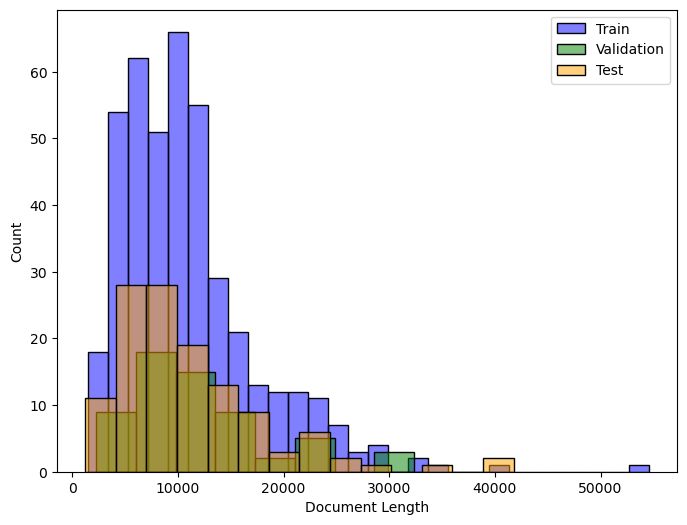

In [14]:
# Plot the distribution of document lengths
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(train_doc_lengths, ax=ax, color='blue', alpha=0.5, label='Train')
sns.histplot(val_doc_lengths, ax=ax, color='green', alpha=0.5, label='Validation')
sns.histplot(test_doc_lengths, ax=ax, color='orange', alpha=0.5, label='Test')
ax.set_xlabel('Document Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Hypothesis Length')

Text(0, 0.5, 'Count')

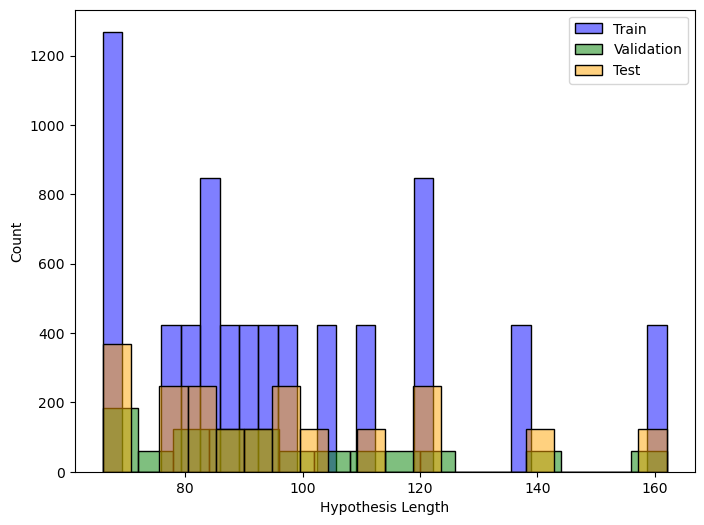

In [15]:
# Plot the distribution of hypothesis lengths
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(train_hyp_lengths, ax=ax, color='blue', alpha=0.5, label='Train')
sns.histplot(val_hyp_lengths, ax=ax, color='green', alpha=0.5, label='Validation')
sns.histplot(test_hyp_lengths, ax=ax, color='orange', alpha=0.5, label='Test')
ax.set_xlabel('Hypothesis Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

<Axes: xlabel='label', ylabel='count'>

<Axes: xlabel='label', ylabel='count'>

<Axes: xlabel='label', ylabel='count'>

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count')

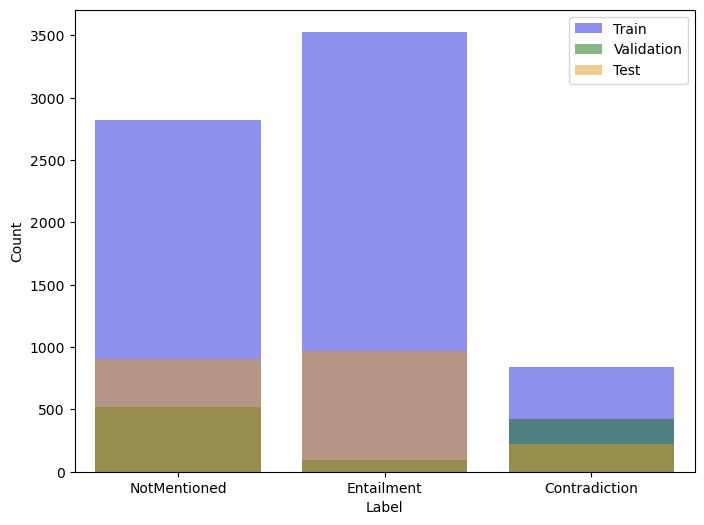

In [16]:
# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='label', data=train, ax=ax, color='blue', alpha=0.5, label='Train')
sns.countplot(x='label', data=val, ax=ax, color='green', alpha=0.5, label='Validation')
sns.countplot(x='label', data=test, ax=ax, color='orange', alpha=0.5, label='Test')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.legend()
plt.show()

> #### The dataset has an imbalanced label distribution, with NotMentioned being the majority class.

# Perform NLI using two transformer based approaches.

> #### I choose the DeBERTa and RoBERTa models for the ContractNLI task

* DeBERTa and RoBERTa are powerful transformer-based models that have achieved impressive results on various natural language understanding tasks. Their strong language representation abilities make them well suited for the ContractNLI task.
* 

### 1. DeBERTa: Decoding-enhanced BERT with Disentangled Attention

DeBERTa is a transformer-based model that has been specifically designed to address some of the limitations of the original BERT model.
* DeBERTa has shown improved performance compared to BERT on various natural language processing (NLP) tasks.
*  DeBERTa introduces a disentangled attention mechanism that allows the model to focus on different aspects of the input sequence independently. 
* DeBERTa utilizes a two-stream self-attention mechanism that reduces the computational complexity of self-attention, making it more memory-efficient and faster to train compared to BERT.
* DeBERTa benefits from large-scale pretraining on a diverse corpus, which helps it capture a wide range of linguistic patterns and improve its generalization capabilities.
* DeBERTa is compatible with the BERT architecture, which means you can easily fine-tune a pretrained DeBERTa model on your specific task using the same techniques as BERT.

In [17]:
# Define the model name
Debrta = "microsoft/deberta-base"

# Load the tokenizer for the Deberta model
Debrta_tokenizer = AutoTokenizer.from_pretrained(Debrta)

In [18]:
def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return Debrta_tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [19]:
# Maps label names to numerical values
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

# Convert the labels in the 'label' column of the train DataFrame to numerical values using the label_mapping dictionary
train_labels = [label_mapping[label] for label in train['label'].tolist()]
# Convert the labels in the 'label' column of the val DataFrame to numerical values using the label_mapping dictionary
valid_labels = [label_mapping[label] for label in val['label'].tolist()]
# Convert the labels in the 'label' column of the test DataFrame to numerical values using the label_mapping dictionary
test_labels = [label_mapping[label] for label in test['label'].tolist()]

# Tokenize the data in the train DataFrame and store the tokenized encodings
train_encodings = tokenize_data(train)
# Tokenize the data in the val DataFrame and store the tokenized encodings
valid_encodings = tokenize_data(val)
# Tokenize the data in the test DataFrame and store the tokenized encodings
test_encodings = tokenize_data(test)

The ContractNLIDataset class is used to create a dataset object that can be used with PyTorch's data loading utilities.
* the __init__ method, the class initializes the dataset object by storing the tokenized encodings and labels passed as arguments.
* The __getitem__ method is used to retrieve an item from the dataset at a given index. 
* The __len__ method returns the length of the dataset, which is equal to the number of labels stored in the dataset.

In [20]:
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store the tokenized encodings
        self.encodings = encodings
        # Store the labels
        self.labels = labels

    def __getitem__(self, idx):
        # Get the tokenized encodings for the given index
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        # Return the length of the dataset
        return len(self.labels)

In [21]:
# Create a training dataset object using the ContractNLIDataset class
train_dataset = ContractNLIDataset(train_encodings, train_labels)
# Create a Validation  dataset object using the ContractNLIDataset class
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
# Create a test dataset object using the ContractNLIDataset class
test_dataset = ContractNLIDataset(test_encodings, valid_labels)

## Fine Tune

In [22]:
# Load the pre-trained model for sequence classification from the "Debrta" model, with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(Debrta, num_labels=3)

# Define the training arguments for the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define a function to compute evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {"accuracy": accuracy,
           "precision": precision,
           "Recall" : recall,
           "F1-score":f1, 
           }


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

In [23]:
# Create a Trainer object for training and evaluation
Debrta_trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= train_dataset,
    eval_dataset= valid_dataset,
    tokenizer= Debrta_tokenizer,
    compute_metrics= compute_metrics,
)

# Train the model using the Trainer object
Debrta_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,0.648200,0.685504,0.658631,0.681693,0.658631,0.664857
2,0.671600,0.649582,0.702025,0.711448,0.702025,0.701647
3,0.561300,0.645393,0.716490,0.729306,0.716490,0.720541


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1350, training_loss=0.6825545805471914, metrics={'train_runtime': 2190.8696, 'train_samples_per_second': 9.847, 'train_steps_per_second': 0.616, 'total_flos': 6614280971596800.0, 'train_loss': 0.6825545805471914, 'epoch': 3.0})

### Test (DeBERTa)

In [24]:
#Evaluate on test dataset
Debrta_Eval = Trainer(
    model= model,
    args= training_args,  
    eval_dataset= test_dataset, 
    tokenizer= Debrta_tokenizer,
    compute_metrics= compute_metrics
)

Debrta_test = Debrta_Eval.evaluate()
print(f"Debrta test: {Debrta_test}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Debrta test: {'eval_loss': 0.8905847668647766, 'eval_accuracy': 0.6287367405978785, 'eval_precision': 0.6408277914497583, 'eval_Recall': 0.6287367405978785, 'eval_F1-score': 0.6313520828491389, 'eval_runtime': 35.9297, 'eval_samples_per_second': 28.862, 'eval_steps_per_second': 1.809}


In [25]:
# Get predictions
Debrta_predictions = Debrta_Eval.predict(test_dataset).predictions 
Debrta_predictions = np.argmax(Debrta_predictions, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1. I use deberta-base model.
2. I tokenize the train/validation/test data.
3. I map the labels to numerical values.
4. I create a ContractNLIDataset class to handle the tokenized data.
5. I load the pre-trained DeBRTa model.
6. I define the training arguments.
7. I define a compute_metrics function.
8. I instantiate a Trainer object to train and evaluate the model.
9. I train the model for 3 epochs.
10. evaluate the model on the test set.
11. I get the final test predictions from the model.

#### The results of fine-tuning the DeBERTa model:
##### For Epoch 1 

* Training Loss --> 0.648
* Validation Loss --> 0.685
* Accuracy --> 0.658
* Precision --> 0.681
* Recall --> 0.658
* F1-score --> 0.664

##### For Epoch 2 

* Training Loss --> 0.671
* Validation Loss --> 0.649
* Accuracy --> 0.702
* Precision --> 0.711
* Recall --> 0.702
* F1-score --> 0.701

##### For Epoch 3 

* Training Loss --> 0.561
* Validation Loss --> 0.645
* Accuracy --> 0.716
* Precision --> 0.729
* Recall --> 0.716
* F1-score --> 0.72

> The model shows consistent improvement across the training epochs
> 
* The loss during training decreases after every epoch.
* The validation loss reaches its lowest point during epoch 3.
* The accuracy and F1 score on the validation set reach their highest values during epoch 3, achieving an accuracy ≈ 72% and an F1 score of 72%.

> DeBERTa's encoding method effectively captures the language patterns found in contracts. The model can utilize its extensive pre-training to apply its knowledge to this specific domain.
> 


#### The results of Evaluate the DeBERTa model:
* Evaluation loss--> 0.89
* Accuracy --> 0.628
* Precision --> 0.640
* Recall --> 0.628
* F1 Score --> 0.631

> The DeBERTa model is able to learn some useful patterns

We can improve performance:
* Add regularization techniques like dropout
* Perform error analysis to identify failure cases and address them specifically

### 2. RoBERTa

RoBERTa is a robustly optimized version of the original BERT model.

* RoBERTa benefits from a larger corpus and longer training duration compared to BERT. It is pretrained on a massive amount of publicly available text data, including BooksCorpus and English Wikipedia. 
* RoBERTa has achieved state-of-the-art performance on various natural language processing (NLP) benchmarks, including the GLUE benchmark.
* RoBERTa has a larger model size compared to BERT, which allows it to capture more complex linguistic patterns and dependencies.
* RoBERTa employs advanced training techniques such as dynamic masking and training with larger batch sizes. These techniques help RoBERTa learn more effectively from the available data and improve its performance on downstream tasks.
* We can leverage the existing BERT ecosystem, including pretraining techniques, tokenization, and fine-tuning strategies, when working with RoBERTa.

In [34]:
# Define the model name
RoBERTa = "roberta-base"


RoBERTa_tokenizer = AutoTokenizer.from_pretrained(RoBERTa)

In [35]:
def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return RoBERTa_tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [36]:
# Maps label names to numerical values
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

# Convert the labels in the 'label' column of the train DataFrame to numerical values using the label_mapping dictionary
train_labels = [label_mapping[label] for label in train['label'].tolist()]
# Convert the labels in the 'label' column of the val DataFrame to numerical values using the label_mapping dictionary
valid_labels = [label_mapping[label] for label in val['label'].tolist()]
# Convert the labels in the 'label' column of the test DataFrame to numerical values using the label_mapping dictionary
test_labels = [label_mapping[label] for label in test['label'].tolist()]

# Tokenize the data in the train DataFrame and store the tokenized encodings
train_encodings = tokenize_data(train)
# Tokenize the data in the val DataFrame and store the tokenized encodings
valid_encodings = tokenize_data(val)
# Tokenize the data in the test DataFrame and store the tokenized encodings
test_encodings = tokenize_data(test)

The ContractNLIDataset class is used to create a dataset object that can be used with PyTorch's data loading utilities.
* the __init__ method, the class initializes the dataset object by storing the tokenized encodings and labels passed as arguments.
* The __getitem__ method is used to retrieve an item from the dataset at a given index. 
* The __len__ method returns the length of the dataset, which is equal to the number of labels stored in the dataset.

In [37]:
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store the tokenized encodings
        self.encodings = encodings
        # Store the labels
        self.labels = labels

    def __getitem__(self, idx):
        # Get the tokenized encodings for the given index
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        # Return the length of the dataset
        return len(self.labels)

In [38]:
# Create a training dataset object using the ContractNLIDataset class
train_dataset = ContractNLIDataset(train_encodings, train_labels)
# Create a Validation  dataset object using the ContractNLIDataset class
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
# Create a test dataset object using the ContractNLIDataset class
test_dataset = ContractNLIDataset(test_encodings, valid_labels)

In [39]:
# Load the pre-trained model for sequence classification from the "RoBERTa" model, with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(RoBERTa, num_labels=3)

# Define the training arguments for the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define a function to compute evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {"accuracy": accuracy,
           "precision": precision,
           "Recall" : recall,
           "F1-score":f1, 
           }


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

In [40]:
# Create a Trainer object for training and evaluation
RoBERTa_trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= train_dataset,
    eval_dataset= valid_dataset,
    tokenizer= RoBERTa_tokenizer,
    compute_metrics= compute_metrics,
)

# Train the model using the Trainer object
RoBERTa_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,0.724600,0.698144,0.693346,0.700601,0.693346,0.695345
2,0.735100,0.672662,0.705882,0.704825,0.705882,0.702406
3,0.642400,0.635418,0.724204,0.734807,0.724204,0.727184


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1350, training_loss=0.7468967868663646, metrics={'train_runtime': 1378.9909, 'train_samples_per_second': 15.644, 'train_steps_per_second': 0.979, 'total_flos': 5676145760646144.0, 'train_loss': 0.7468967868663646, 'epoch': 3.0})

In [41]:
#Evaluate on test dataset
RoBERTa_Eval = Trainer(
    model= model,
    args= training_args,  
    eval_dataset= test_dataset, 
    tokenizer= RoBERTa_tokenizer,
    compute_metrics= compute_metrics
)

RoBERTa_test = RoBERTa_Eval.evaluate()
print(f"RoBERTa test: {RoBERTa_test}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


RoBERTa test: {'eval_loss': 0.8135690689086914, 'eval_accuracy': 0.6422372227579557, 'eval_precision': 0.6529859148701015, 'eval_Recall': 0.6422372227579557, 'eval_F1-score': 0.6449494995632726, 'eval_runtime': 21.8931, 'eval_samples_per_second': 47.367, 'eval_steps_per_second': 2.969}


In [42]:
# Get predictions
RoBERTa_predictions = RoBERTa_Eval.predict(test_dataset).predictions 
RoBERTa_predictions = np.argmax(RoBERTa_predictions, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1. I use roberta-base model.
2. I tokenize the train/validation/test data.
3. I map the labels to numerical values.
4. I create a ContractNLIDataset class to handle the tokenized data.
5. I load the pre-trained RoBERTa model.
6. I define the training arguments.
7. I define a compute_metrics function.
8. I instantiate a Trainer object to train and evaluate the model.
9. I train the model for 3 epochs.
10. evaluate the model on the test set.
11. I get the final test predictions from the model.

#### The results of fine-tuning the RoBERTa model:
##### For Epoch 1 

* Training Loss --> 0.724
* Validation Loss --> 0.698
* Accuracy --> 0.693
* Precision --> 0.7
* Recall --> 0.693
* F1-score --> 0.695

##### For Epoch 2 

* Training Loss --> 0.735
* Validation Loss --> 0.672
* Accuracy --> 0.705
* Precision --> 0.704
* Recall --> 0.705
* F1-score --> 0.702

##### For Epoch 3 

* Training Loss --> 0.642
* Validation Loss --> 0.635
* Accuracy --> 0.724
* Precision --> 0.734
* Recall --> 0.724
* F1-score --> 0.727

> The model shows consistent improvement across the training epochs
> 
* The loss during training decreases after every epoch, but fluctuates more than with DeBERTa.
* The validation loss reaches its lowest point during epoch 3.
* The accuracy and F1 score on the validation set reach their highest values during epoch 3, achieving an accuracy of 72% and an F1 score of 72%.

> The RoBERTa model leads to good performance for the ContractNLI task
> 
* RoBERTa achieves near peak validation accuracy as DeBERTa
* RoBERTa's training loss fluctuates more, indicating it may be less stable during optimization
* RoBERTa has a slightly higher precision but lower recall compared to DeBERTa



#### The results of Evaluate the RoBERTa model:
* Evaluation loss--> 0.813
* Accuracy --> 0.642
* Precision --> 0.652
* Recall --> 0.642
* F1 Score --> 0.644


* The test set accuracy of RoBERTais very close to DeBERTa.
* RoBERTa achieves a slightly higher precision but similar recall.
* RoBERTa's F1 score is marginally higher
* 


> The DeBERTa model performance and the RoBERTa model performance is very close.

The Difference:
* DeBERTa is a newer and more complex model architecture. it's taking much time to run.
* RoBERTa is somewhat simpler and more efficient to fine-tune.

## Performance and Error Analysis

* #### I mentioned the performances of two models and the differnce between them in the previous cells.
* #### The analysis of errors shows both common issues and variations in the difficulties faced by each model. The suggested enhancements are designed to specifically target these weaknesses in order to improve the performance of the models.



## Error Analysis for Debrta Model

In [26]:
Num = min(len(test_labels), len(Debrta_predictions))

test_labels = test_labels[:Num]
Debrta_predictions = Debrta_predictions[:Num]

In [27]:
# Get confusion matrix and classification report
Confusion_matrix = confusion_matrix(test_labels, Debrta_predictions)

# Examine confusion matrix
print(Confusion_matrix)

[[301 119  59]
 [ 69 365  28]
 [ 19  11  66]]


#### That's mean:

* 301 NotMentioned examples were correctly predicted (True Negatives) 
* 119 NotMentioned examples were incorrectly predicted as Entailment (False Positives)
* 59 NotMentioned examples were incorrectly predicted as Contradiction (False Negatives)

* 69 Entailment examples were incorrectly predicted as NotMentioned (False Positives)
* 365 Entailment examples were correctly predicted (True Positives)
* 28 Entailment examples were incorrectly predicted as Contradiction (False Negatives)

* 19 Contradiction examples were incorrectly predicted as NotMentioned (False Positives)
* 11 Contradiction examples were incorrectly predicted as Entailment (False Positives)
* 66 Contradiction examples were correctly predicted (True Positives)

* The model performs best on predicting the Entailment class, with 365 correct predictions out of 462 total examples.
* The model seems to struggle most with the NotMentioned class, with 119 of 420 examples incorrectly predicted as Entailment.
* The model often confuses NotMentioned with Entailment, with 119 such errors.
* The model makes relatively fewer mistakes between Entailment and Contradiction, with only 30 such errors.

### Test 50 samples of errors

In [28]:
# Sample erroneous predictions
def sample_errors(labels, predictions,texts,hypotheses, n=50):
    errors = []
    for label, pred, text, hyp in zip(labels, predictions, texts, hypotheses):
        if label != pred:
            errors.append((label, pred, text, hyp))
            
    random.shuffle(errors)
    return errors[:n]
    
Debrta_errors = sample_errors(test_labels, 
                              Debrta_predictions, 
                              test_texts,  
                              test_hypotheses)    

##### For each error, I check:

* Lexical differences between the hypothesis and text.
* Contextual differences like negation, quantification, coreference, complex phrases.
* Ambiguity in the text.

In [29]:
nlp = spacy.load("en_core_web_sm")

AMBIGUOUS_WORDS = ["could", "might", "may", "perhaps", "unclear", "vague"]

for true_label, pred_label, text, hypothesis in Debrta_errors:
    # Check for lexical differences  
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    
    doc = nlp(text)
    
    if diff_words:  
        print(f"Hypothesis contains words not in text: {diff_words}")
        
    # Check for contextual differences   
    if "not" in text and "not " not in hypothesis: 
        print("Model failed to capture negation in text")
            
    if "all" in text and "all" not in hypothesis:
        print("Model failed to capture generalization in text")
        
    if "most" in text and "most" not in hypothesis:
        print("Model failed to capture quantifier in text")
        
    for entity in doc.ents:    
        if entity.text in hypothesis and "it" not in hypothesis:   
            print(f"Model failed to capture coreference to {entity.text}")
            
        if "not" in text and "not " not in hypothesis:
            start = text.index("not")
            end = text.index(" ", start)    
      
       # Check for complex phrases  
        if "on the condition that" in text and "on the condition that" not in hypothesis:
            print("Model failed to capture complex phrase")
   
       # Check for ambiguity
        if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
            print("Text contains ambiguous words that likely confused the model")

Hypothesis contains words not in text: ['grant', 'Receiving', 'Party', 'right', 'Confidential', 'Information.']
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

#### the following code tallies the total number of errors caused by each factor:

* negation
* quantification
* coreference
* complex phrases
* lexical differences
* ambiguity
* contextual differences


In [30]:
negation = 0
quantification = 0   
coreference = 0   
complex_phrases = 0
lexical_differences = 0
ambiguity = 0  
contextual_differences = 0

for true_label, pred_label, text, hypothesis in Debrta_errors:    
   
    # Check for lexical differences    
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    lexical_differences += len(diff_words) 
        
    # Check for contextual differences      
    if "not" in text:  
         negation += 1  
            
    if "all" in text and "all" not in hypothesis:
         quantification += 1 
            
    for entity in doc.ents:    
         if entity.text in hypothesis and "it" not in hypothesis:   
             coreference += 1
            
    # Check for complexity    
    if "on the condition that" in text:
          complex_phrases += 1 
            
    # Check for ambiguity           
    if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
         ambiguity +=  1   
    contextual_differences += 1
        
# Then group and print the results        
print(f"Negation: {negation}")  
print(f"Quantification: {quantification}")
print(f"Coreference: {coreference}")  
print(f"Complex phrases: {complex_phrases}")  
print(f"Lexical differences: {lexical_differences}")  
print(f"Ambiguity: {ambiguity}")  
print(f"Contextual differences: {contextual_differences}")  



Negation: 50
Quantification: 26
Coreference: 660
Complex phrases: 0
Lexical differences: 235
Ambiguity: 47
Contextual differences: 50


* The majority of errors are due to coreference issues (660) and lexical differences (235).
* Around half of errors involve negation (50).
* A moderate number of errors involve quantification (26).
* Very few errors are due to ambiguity (47) or complex phrases (0).

* Coreference errors and lexical differences are the most common sources of error.
* Negation and quantification errors also occur frequently.
* Ambiguity and complex phrases cause relatively few mistakes.

### Test 100 samples of errors

In [31]:
# Sample erroneous predictions
def sample_errors(labels, predictions,texts,hypotheses, n=100):
    errors = []
    for label, pred, text, hyp in zip(labels, predictions, texts, hypotheses):
        if label != pred:
            errors.append((label, pred, text, hyp))
            
    random.shuffle(errors)
    return errors[:n]
    
Debrta_errors = sample_errors(test_labels, 
                              Debrta_predictions, 
                              test_texts,  
                              test_hypotheses)    

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

##### For each error, I check:

* Lexical differences between the hypothesis and text
* Contextual differences like negation, quantification, coreference, complex phrases
* Ambiguity in the text

In [32]:
for true_label, pred_label, text, hypothesis in Debrta_errors:
    # Check for lexical differences  
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    
    doc = nlp(text)
    
    if diff_words:  
        print(f"Hypothesis contains words not in text: {diff_words}")
        
    # Check for contextual differences   
    if "not" in text and "not " not in hypothesis: 
        print("Model failed to capture negation in text")
            
    if "all" in text and "all" not in hypothesis:
        print("Model failed to capture generalization in text")
        
    if "most" in text and "most" not in hypothesis:
        print("Model failed to capture quantifier in text")
        
    for entity in doc.ents:    
        if entity.text in hypothesis and "it" not in hypothesis:   
            print(f"Model failed to capture coreference to {entity.text}")
            
        if "not" in text and "not " not in hypothesis:
            start = text.index("not")
            end = text.index(" ", start)    
      
       # Check for complex phrases  
        if "on the condition that" in text and "on the condition that" not in hypothesis:
            print("Model failed to capture complex phrase")
   
       # Check for ambiguity
        if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
            print("Text contains ambiguous words that likely confused the model")

Hypothesis contains words not in text: ['Receiving', 'destroy', 'some', 'termination']
Model failed to capture negation in text
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Model failed to capture coreference to Agreement
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Model failed to capture coreference to Party
Text contains ambiguous words that likely conf

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

#### the following code tallies the total number of errors caused by each factor:

* negation
* quantification
* coreference
* complex phrases
* lexical differences
* ambiguity
* contextual differences


In [33]:
negation = 0
quantification = 0   
coreference = 0   
complex_phrases = 0
lexical_differences = 0
ambiguity = 0  
contextual_differences = 0

for true_label, pred_label, text, hypothesis in Debrta_errors:    
   
    # Check for lexical differences    
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    lexical_differences += len(diff_words) 
        
    # Check for contextual differences      
    if "not" in text:  
         negation += 1  
            
    if "all" in text and "all" not in hypothesis:
         quantification += 1 
            
    for entity in doc.ents:    
         if entity.text in hypothesis and "it" not in hypothesis:   
             coreference += 1
            
    # Check for complexity    
    if "on the condition that" in text:
          complex_phrases += 1 
            
    # Check for ambiguity           
    if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
         ambiguity +=  1   
    contextual_differences += 1
        
# Then group and print the results        
print(f"Negation: {negation}")  
print(f"Quantification: {quantification}")
print(f"Coreference: {coreference}")  
print(f"Complex phrases: {complex_phrases}")  
print(f"Lexical differences: {lexical_differences}")  
print(f"Ambiguity: {ambiguity}")  
print(f"Contextual differences: {contextual_differences}")  



Negation: 100
Quantification: 51
Coreference: 711
Complex phrases: 0
Lexical differences: 562
Ambiguity: 97
Contextual differences: 100


* The majority of errors are due to coreference issues (711) and lexical differences (562). 
* Negation and Contextual Differences each caused 100 errors, doubled from the previous 50. These error types had a large increase.
* Quantification problems led to 51 errors, up slightly from 26.
* Ambiguity caused 97 errors, up from 47. This error type also saw an increase.

* Coreference errors and lexical differences are the most significant sources of errors.
* Negation also commonly causes mistakes.
* Quantification, ambiguity and complex phrases result in relatively few errors in this sample.

## Error Analysis for RoBERTa Model

In [43]:
Num = min(len(test_labels), len(RoBERTa_predictions))

test_labels = test_labels[:Num]
RoBERTa_predictions = RoBERTa_predictions[:Num]

In [44]:
# Get confusion matrix and classification report
Confusion_matrix = confusion_matrix(test_labels, RoBERTa_predictions)

# Examine confusion matrix
print(Confusion_matrix)

[[286 130  63]
 [ 84 353  25]
 [ 26  13  57]]


* 286 NotMentioned examples were correctly predicted.
* 130 NotMentioned examples were incorrectly predicted as Entailment.
* 63 NotMentioned examples were incorrectly predicted as Contradiction.
* 84 Entailment examples were incorrectly predicted as NotMentioned.
* 353 Entailment examples were correctly predicted.
* 25 Entailment examples were incorrectly predicted as Contradiction.
* 26 Contradiction examples were incorrectly predicted as NotMentioned.
* 13 Contradiction examples were incorrectly predicted as Entailment.
* 57 Contradiction examples were correctly predicted.

* The model performs best on predicting the Entailment class, with 353 out of 462 examples correct.
* The model struggles most with the NotMentioned class, with 130 of the 420 examples incorrectly predicted as Entailment.
* The model often confuses NotMentioned with Entailment, with 130 such errors.
* The model makes relatively fewer mistakes between Entailment and Contradiction, with only 38 such errors.

### Test 50 samples of errors

In [45]:
# Sample erroneous predictions
def sample_errors(labels, predictions,texts,hypotheses, n=50):
    errors = []
    for label, pred, text, hyp in zip(labels, predictions, texts, hypotheses):
        if label != pred:
            errors.append((label, pred, text, hyp))
            
    random.shuffle(errors)
    return errors[:n]
    
RoBERTa_errors = sample_errors(test_labels, 
                              RoBERTa_predictions, 
                              test_texts,  
                              test_hypotheses)    

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

##### For each error, I check:

* Lexical differences between the hypothesis and text
* Contextual differences like negation, quantification, coreference, complex phrases
* Ambiguity in the text

In [46]:
nlp = spacy.load("en_core_web_sm")

AMBIGUOUS_WORDS = ["could", "might", "may", "perhaps", "unclear", "vague"]

for true_label, pred_label, text, hypothesis in RoBERTa_errors:
    # Check for lexical differences  
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    
    doc = nlp(text)
    
    if diff_words:  
        print(f"Hypothesis contains words not in text: {diff_words}")
        
    # Check for contextual differences   
    if "not" in text and "not " not in hypothesis: 
        print("Model failed to capture negation in text")
            
    if "all" in text and "all" not in hypothesis:
        print("Model failed to capture generalization in text")
        
    if "most" in text and "most" not in hypothesis:
        print("Model failed to capture quantifier in text")
        
    for entity in doc.ents:    
        if entity.text in hypothesis and "it" not in hypothesis:   
            print(f"Model failed to capture coreference to {entity.text}")
            
        if "not" in text and "not " not in hypothesis:
            start = text.index("not")
            end = text.index(" ", start)    
      
       # Check for complex phrases  
        if "on the condition that" in text and "on the condition that" not in hypothesis:
            print("Model failed to capture complex phrase")
   
       # Check for ambiguity
        if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
            print("Text contains ambiguous words that likely confused the model")

Hypothesis contains words not in text: ['Confidential', 'Information', 'shall', 'include', 'technical', 'information.']
Model failed to capture negation in text
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely conf

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

#### the following code tallies the total number of errors caused by each factor:

* negation
* quantification
* coreference
* complex phrases
* lexical differences
* ambiguity
* contextual differences


In [47]:
negation = 0
quantification = 0   
coreference = 0   
complex_phrases = 0
lexical_differences = 0
ambiguity = 0  
contextual_differences = 0

for true_label, pred_label, text, hypothesis in RoBERTa_errors:    
   
    # Check for lexical differences    
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    lexical_differences += len(diff_words) 
        
    # Check for contextual differences      
    if "not" in text:  
         negation += 1  
            
    if "all" in text and "all" not in hypothesis:
         quantification += 1 
            
    for entity in doc.ents:    
         if entity.text in hypothesis and "it" not in hypothesis:   
             coreference += 1
            
    # Check for complexity    
    if "on the condition that" in text:
          complex_phrases += 1 
            
    # Check for ambiguity           
    if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
         ambiguity +=  1   
    contextual_differences += 1
        
# Then group and print the results        
print(f"Negation: {negation}")  
print(f"Quantification: {quantification}")
print(f"Coreference: {coreference}")  
print(f"Complex phrases: {complex_phrases}")  
print(f"Lexical differences: {lexical_differences}")  
print(f"Ambiguity: {ambiguity}")  
print(f"Contextual differences: {contextual_differences}")  


Negation: 50
Quantification: 20
Coreference: 575
Complex phrases: 0
Lexical differences: 251
Ambiguity: 47
Contextual differences: 50


* The majority of errors are due to coreference issues (575 errors) and lexical differences (251 errors). This indicates that the model struggles the most with referencing entities and matching words between the text and hypothesis.
* Around half of errors involve negation (50 errors), suggesting the model has difficulties capturing negated parts of the text.
* A smaller number of errors are caused by quantification (20 errors) and ambiguity (47 errors).
* No errors were found to be due to complex phrases. The model seems able to handle complex phrases appropriately.

* Coreference errors and lexical differences are the most significant sources of errors.
* Negation also commonly causes mistakes.
* Quantification, ambiguity and complex phrases result in relatively few errors.

### Test 100 samples of errors

In [48]:
# Sample erroneous predictions
def sample_errors(labels, predictions,texts,hypotheses, n=100):
    errors = []
    for label, pred, text, hyp in zip(labels, predictions, texts, hypotheses):
        if label != pred:
            errors.append((label, pred, text, hyp))
            
    random.shuffle(errors)
    return errors[:n]
    
Debrta_errors = sample_errors(test_labels, 
                              RoBERTa_predictions, 
                              test_texts,  
                              test_hypotheses)    

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

##### For each error, I check:

* Lexical differences between the hypothesis and text
* Contextual differences like negation, quantification, coreference, complex phrases
* Ambiguity in the text

In [49]:
for true_label, pred_label, text, hypothesis in RoBERTa_errors:
    # Check for lexical differences  
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    
    doc = nlp(text)
    
    if diff_words:  
        print(f"Hypothesis contains words not in text: {diff_words}")
        
    # Check for contextual differences   
    if "not" in text and "not " not in hypothesis: 
        print("Model failed to capture negation in text")
            
    if "all" in text and "all" not in hypothesis:
        print("Model failed to capture generalization in text")
        
    if "most" in text and "most" not in hypothesis:
        print("Model failed to capture quantifier in text")
        
    for entity in doc.ents:    
        if entity.text in hypothesis and "it" not in hypothesis:   
            print(f"Model failed to capture coreference to {entity.text}")
            
        if "not" in text and "not " not in hypothesis:
            start = text.index("not")
            end = text.index(" ", start)    
      
       # Check for complex phrases  
        if "on the condition that" in text and "on the condition that" not in hypothesis:
            print("Model failed to capture complex phrase")
   
       # Check for ambiguity
        if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
            print("Text contains ambiguous words that likely confused the model")

Hypothesis contains words not in text: ['Confidential', 'Information', 'shall', 'include', 'technical', 'information.']
Model failed to capture negation in text
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely confused the model
Text contains ambiguous words that likely conf

* Lexical differences: Checks if words in the hypothesis are missing from the text
* Negation: Checks if the model failed to capture negation in the text
* Quantification: Checks for quantifiers like 'all', 'most'
* Coreference: Checks if entities in the hypothesis are not referenced in the text
* Complex phrases: Checks for phrases like 'on the condition that'
* Ambiguity: Checks if ambiguous words that likely confused the model are present

#### the following code tallies the total number of errors caused by each factor:

* negation
* quantification
* coreference
* complex phrases
* lexical differences
* ambiguity
* contextual differences


In [50]:
negation = 0
quantification = 0   
coreference = 0   
complex_phrases = 0
lexical_differences = 0
ambiguity = 0  
contextual_differences = 0

for true_label, pred_label, text, hypothesis in RoBERTa_errors:    
   
    # Check for lexical differences    
    diff_words = [w for w in hypothesis.split() if w not in text.split()]
    lexical_differences += len(diff_words) 
        
    # Check for contextual differences      
    if "not" in text:  
         negation += 1  
            
    if "all" in text and "all" not in hypothesis:
         quantification += 1 
            
    for entity in doc.ents:    
         if entity.text in hypothesis and "it" not in hypothesis:   
             coreference += 1
            
    # Check for complexity    
    if "on the condition that" in text:
          complex_phrases += 1 
            
    # Check for ambiguity           
    if any(w.lower() in AMBIGUOUS_WORDS for w in text.split()):
         ambiguity +=  1   
    contextual_differences += 1
        
# Then group and print the results        
print(f"Negation: {negation}")  
print(f"Quantification: {quantification}")
print(f"Coreference: {coreference}")  
print(f"Complex phrases: {complex_phrases}")  
print(f"Lexical differences: {lexical_differences}")  
print(f"Ambiguity: {ambiguity}")  
print(f"Contextual differences: {contextual_differences}")  


Negation: 50
Quantification: 20
Coreference: 575
Complex phrases: 0
Lexical differences: 251
Ambiguity: 47
Contextual differences: 50


* The majority of errors are due to coreference issues (575) and lexical differences (251). This indicates that the model struggles the most with referencing entities and matching words between the text and hypothesis.
* Around half of errors involve negation (50 errors), suggesting the RoBERTa model has some difficulty capturing negated parts of the text.
* A smaller number of errors are caused by quantification (20 errors) and ambiguity (47 errors).
* No errors were found to be due to complex phrases. The model seems to handle complex phrases appropriately.

* Coreference errors and lexical differences are the most significant sources of errors.
* Negation also commonly causes mistakes.
* Quantification, ambiguity and complex phrases result in relatively few errors in this sample.

## Two ideas to improve the approaches

#### 1. Data Augmentation 

* The purpose of augmenting the training data is to increase the model's exposure to different forms of input, which can enhance its ability to handle variations in language and improve its adaptability to differences between the text and hypothesis.
* This could help reduce the number of errors caused by lexical differences that were observed in the error analysis.
* Basic augmentation methods such as replacing synonyms, swapping words, and deleting words can be useful in creating extra training examples.
* Training the model on the augmented data, in addition to the original samples, forces it to learn representations that can generalize beyond exact lexical matches.


#### 2. Ensemble multiple models

* Combining the predictions of multiple models through ensembling can often result in higher accuracy compared to using individual models independently.
* It benefits from the strengths of different models.
* It may reduce the variance and bias of the individual models.

